# Logistic Regression Using Python

## Example: Acceptance of Personal Loan


After partitioning the data into training (60%) and validation (40%) sets, we fit a logistic regression model.


## Import required packages


In [1]:


from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score


no display found. Using non-interactive Agg backend


## Table 10.2
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [2]:
bank_df = dmba.load_data('UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
print(bank_df.columns)

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal_Loan', 'Securities_Account', 'CD_Account',
       'Online', 'CreditCard'],
      dtype='object')


In [7]:
# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}

education_cat = bank_df.Education.cat.rename_categories(new_categories)
print(education_cat)
bank_df.Education = education_cat
print(bank_df)

0                   Undergrad
1                   Undergrad
2                   Undergrad
3                    Graduate
4                    Graduate
                ...          
4995    Advanced/Professional
4996                Undergrad
4997    Advanced/Professional
4998                 Graduate
4999                Undergrad
Name: Education, Length: 5000, dtype: category
Categories (3, object): ['Undergrad', 'Graduate', 'Advanced/Professional']
      Age  Experience  Income  Family  CCAvg              Education  Mortgage  \
0      25           1      49       4    1.6              Undergrad         0   
1      45          19      34       3    1.5              Undergrad         0   
2      39          15      11       1    1.0              Undergrad         0   
3      35           9     100       1    2.7               Graduate         0   
4      35           8      45       4    1.0               Graduate         0   
...   ...         ...     ...     ...    ...                  

In [8]:
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.493436061176814
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.037685    0.039202  0.058844  0.612251  0.240489  0.001012   

       Securities_Account  CD_Account    Online  CreditCard  \
coeff            -1.01428    3.649097 -0.678306   -0.958283   

       Education_Graduate  Education_Advanced/Professional  
coeff            4.202148                         4.355761  

AIC -709.1524769205962


In [3]:
# Set to True to calculate logistic regression using Income only
if False:
    predictors = ['Income']
    outcome = 'Personal_Loan'

    y = bank_df[outcome]
    X = bank_df[predictors]

    # partition data
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

    # fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
    logit_reg_income = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    logit_reg_income.fit(train_X, train_y)

    print('intercept ', logit_reg_income.intercept_[0])
    print(pd.DataFrame({'coefficient': logit_reg_income.coef_[0]}, index=X.columns).transpose())
    print()
    print('AIC', AIC_score(valid_y, logit_reg_income.predict(valid_X), df = len(train_X.columns) + 1))

In [4]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976092  0.023908          0
932        0  0.330986  0.669014          1
2721       1  0.031431  0.968569          1
702        1  0.985893  0.014107          0


## Table 10.4

In [5]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Figure 10.3

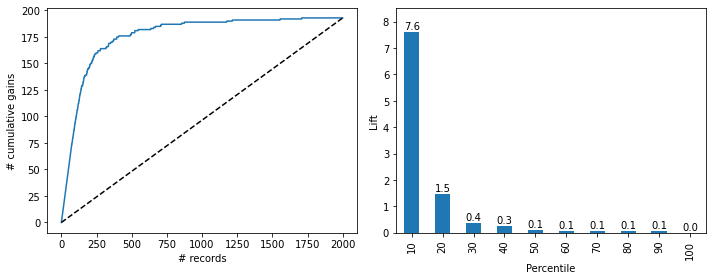

In [6]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()